In [1]:
import os
import numpy as np # linear algebra
from numpy import newaxis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam # this for python 3.10
import math, time
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import shap

Using TensorFlow backend.
e:\anaconda\envs\shapenv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
e:\anaconda\envs\shapenv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
e:\anaconda\envs\shapenv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
e:\anaconda\envs\shapenv\lib\site-packages\tensorflow\python\framework\dtypes.py

If running shap change version variable to 3.7, if not set to anthing else.

In [2]:
from sys import version
versioncheck = version[:3] == '3.7'
versioncheck

True

In [3]:
if versioncheck:
    from keras.optimizers import Adam
else:
    pass

In [4]:
os.chdir('../..')

In [5]:
dataset = pd.read_csv('data/data_nominal_clean.csv', sep=';',  index_col='date',  parse_dates=['date'])

In [6]:
pd.DataFrame(dataset['Gold'])

,Gold
date,
1986-01-02,326.30
1986-01-03,326.75
1986-01-06,328.00
1986-01-07,330.00
1986-01-08,332.60
...,...
2022-12-30,1813.75
2023-01-03,1843.25
2023-01-04,1857.30


lagging gold col

In [7]:
dataset['GoldLag']  = dataset['Gold'].shift(20)

In [8]:
df = dataset[['Gold', 'GoldLag']]
df

,Gold,GoldLag
date,,
1986-01-02,326.30,NaN
1986-01-03,326.75,NaN
1986-01-06,328.00,NaN
1986-01-07,330.00,NaN
1986-01-08,332.60,NaN
...,...,...
2022-12-30,1813.75,1753.50
2023-01-03,1843.25,1803.15
2023-01-04,1857.30,1784.75


In [9]:
df.dropna(inplace=True)
df


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Gold,GoldLag
date,,
1986-01-30,358.00,326.30
1986-01-31,350.50,326.75
1986-02-03,347.30,328.00
1986-02-04,338.60,330.00
1986-02-05,337.30,332.60
...,...,...
2022-12-30,1813.75,1753.50
2023-01-03,1843.25,1803.15
2023-01-04,1857.30,1784.75


---
# LSTM univariate

In [10]:
X_train, y_train = df['GoldLag'].iloc[:-60].values, df['Gold'].iloc[:-60].values
X_test, y_test = df['GoldLag'].iloc[-60:-40].values, df['Gold'].iloc[-60:-40].values

In [11]:
scx = MinMaxScaler(feature_range=(0,1))
scy = MinMaxScaler(feature_range=(0,1))
X_trains = scx.fit_transform(X_train.reshape(-1,1))
y_trains = scy.fit_transform(y_train.reshape(-1,1))

In [12]:
adam = Adam(lr=0.001)

In [13]:
# this is needed for python 3.7 , for keras and tf in python 3.10 comment out this cell
if versioncheck:
    from numpy import newaxis

    X_trains =X_trains[:,:,newaxis]
    y_trains.reshape(1,-1)
else:
    pass

In [14]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_trains.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "relu"))

model.compile(loss='mse', optimizer=adam)

print ('model compiled')

print (model.summary())

model compiled
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 100)            60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1) 

In [15]:
history = model.fit(X_trains, y_trains, batch_size=64, epochs=100, verbose=2, use_multiprocessing=True)


Epoch 1/100
 - 2s - loss: 0.0386
Epoch 2/100
 - 1s - loss: 0.0028
Epoch 3/100
 - 1s - loss: 0.0025
Epoch 4/100
 - 1s - loss: 0.0022
Epoch 5/100
 - 1s - loss: 0.0020
Epoch 6/100
 - 1s - loss: 0.0019
Epoch 7/100
 - 1s - loss: 0.0019
Epoch 8/100
 - 1s - loss: 0.0019
Epoch 9/100
 - 1s - loss: 0.0018
Epoch 10/100
 - 1s - loss: 0.0018
Epoch 11/100
 - 1s - loss: 0.0017
Epoch 12/100
 - 1s - loss: 0.0016
Epoch 13/100
 - 1s - loss: 0.0016
Epoch 14/100
 - 1s - loss: 0.0016
Epoch 15/100
 - 1s - loss: 0.0014
Epoch 16/100
 - 1s - loss: 0.0015
Epoch 17/100
 - 1s - loss: 0.0014
Epoch 18/100
 - 1s - loss: 0.0015
Epoch 19/100
 - 1s - loss: 0.0013
Epoch 20/100
 - 1s - loss: 0.0014
Epoch 21/100
 - 1s - loss: 0.0014
Epoch 22/100
 - 1s - loss: 0.0014
Epoch 23/100
 - 1s - loss: 0.0013
Epoch 24/100
 - 1s - loss: 0.0013
Epoch 25/100
 - 1s - loss: 0.0013
Epoch 26/100
 - 1s - loss: 0.0013
Epoch 27/100
 - 1s - loss: 0.0012
Epoch 28/100
 - 1s - loss: 0.0012
Epoch 29/100
 - 1s - loss: 0.0013
Epoch 30/100
 - 1s - l

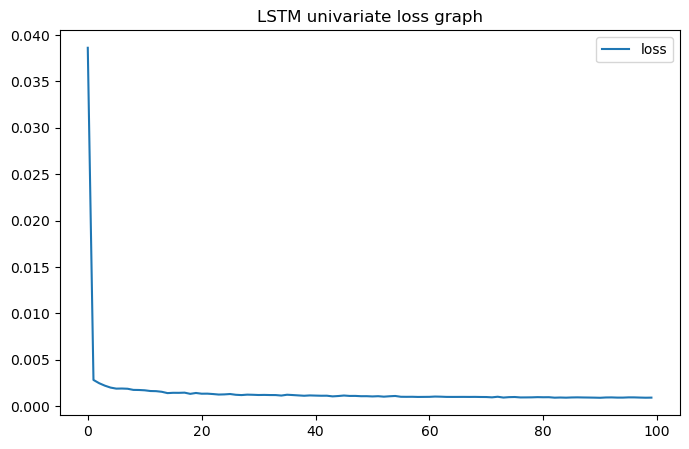

In [16]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.title('LSTM univariate loss graph')
plt.show()

In [17]:
sctsx = MinMaxScaler(feature_range=(0,1))
sctsx.fit(X_test.reshape(-1,1))
X_tests = sctsx.transform(X_test.reshape(-1,1))

In [18]:
sctsy = MinMaxScaler(feature_range=(0,1))
sctsy.fit(y_test.reshape(-1,1))

MinMaxScaler()

In [19]:
# version check for reshape
if versioncheck:
    X_tests =X_tests[:,:,newaxis]
else:
    pass

In [20]:
fhats = model.predict(X_tests)

In [21]:
hat_inv = sctsy.inverse_transform(fhats)
uhat_inv_p1 = hat_inv

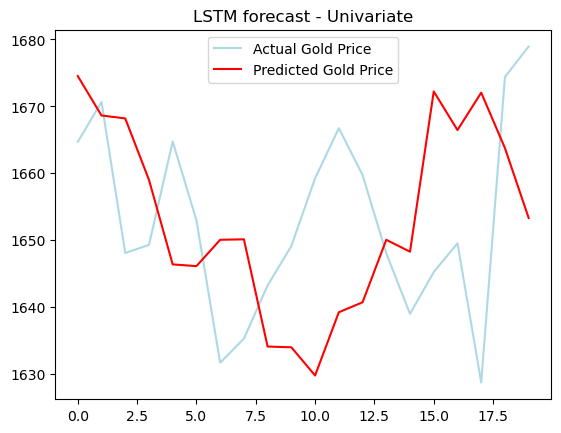

<Figure size 640x480 with 0 Axes>

In [22]:
plt.plot(y_test, color='lightblue', label='Actual Gold Price')
plt.plot(hat_inv, color='red',label='Predicted Gold Price')
plt.title('LSTM forecast - Univariate')
plt.legend()
plt.show()
plt.clf()

In [23]:
# metrics
mae_uv = mean_absolute_error(y_test, hat_inv)
mape_uv = mean_absolute_percentage_error(y_test, hat_inv)
mse_uv = mean_squared_error(y_test, hat_inv)
rmse_uv = np.sqrt(mse_uv)

In [24]:
print(f'MAE: {mae_uv}\nMAPE: {mape_uv}\nMSE: {mse_uv}\nRMSE: {rmse_uv}')

MAE: 16.756301269531274
MAPE: 0.01014588789780317
MSE: 379.4668483669168
RMSE: 19.479908838773266


In [25]:
res_dict = {'model':[], 'type':[], 'period':[], 'MAE':[], 'MAPE':[], 'MSE':[], 'RMSE':[]}

res_dict['model'].append('LSTM')
res_dict['type'].append('univariate')
res_dict['period'].append(1)
res_dict['MAE'].append(mae_uv)
res_dict['MAPE'].append(mape_uv)
res_dict['MSE'].append(mse_uv)
res_dict['RMSE'].append(rmse_uv)

# Univariate period 2

In [26]:
X_train, y_train = df['GoldLag'].iloc[:-40].values, df['Gold'].iloc[:-40].values
X_test, y_test = df['GoldLag'].iloc[-40:-20].values, df['Gold'].iloc[-40:-20].values

In [27]:
scx = MinMaxScaler(feature_range=(0,1))
scy = MinMaxScaler(feature_range=(0,1))
X_trains = scx.fit_transform(X_train.reshape(-1,1))
y_trains = scy.fit_transform(y_train.reshape(-1,1))

In [28]:
adam = Adam(lr=0.001)

In [29]:
# this is needed for python 3.7 , for keras and tf in python 3.10 comment out this cell
if versioncheck:
    from numpy import newaxis

    X_trains =X_trains[:,:,newaxis]
    y_trains.reshape(1,-1)
else:
    pass

In [30]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_trains.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "relu"))

model.compile(loss='mse', optimizer=adam)

print ('model compiled')

print (model.summary())

model compiled
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 50)             10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 100)            60400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1) 

In [31]:
history = model.fit(X_trains, y_trains, batch_size=64, epochs=100, verbose=2, use_multiprocessing=True)

Epoch 1/100
 - 2s - loss: 0.0407
Epoch 2/100
 - 1s - loss: 0.0031
Epoch 3/100
 - 1s - loss: 0.0028
Epoch 4/100
 - 1s - loss: 0.0024
Epoch 5/100
 - 1s - loss: 0.0024
Epoch 6/100
 - 1s - loss: 0.0023
Epoch 7/100
 - 1s - loss: 0.0021
Epoch 8/100
 - 1s - loss: 0.0020
Epoch 9/100
 - 1s - loss: 0.0020
Epoch 10/100
 - 1s - loss: 0.0019
Epoch 11/100
 - 1s - loss: 0.0019
Epoch 12/100
 - 1s - loss: 0.0018
Epoch 13/100
 - 1s - loss: 0.0018
Epoch 14/100
 - 1s - loss: 0.0016
Epoch 15/100
 - 1s - loss: 0.0016
Epoch 16/100
 - 1s - loss: 0.0016
Epoch 17/100
 - 1s - loss: 0.0015
Epoch 18/100
 - 1s - loss: 0.0016
Epoch 19/100
 - 1s - loss: 0.0015
Epoch 20/100
 - 1s - loss: 0.0015
Epoch 21/100
 - 1s - loss: 0.0015
Epoch 22/100
 - 1s - loss: 0.0015
Epoch 23/100
 - 1s - loss: 0.0014
Epoch 24/100
 - 1s - loss: 0.0015
Epoch 25/100
 - 1s - loss: 0.0014
Epoch 26/100
 - 1s - loss: 0.0014
Epoch 27/100
 - 1s - loss: 0.0014
Epoch 28/100
 - 1s - loss: 0.0014
Epoch 29/100
 - 1s - loss: 0.0013
Epoch 30/100
 - 1s - lo

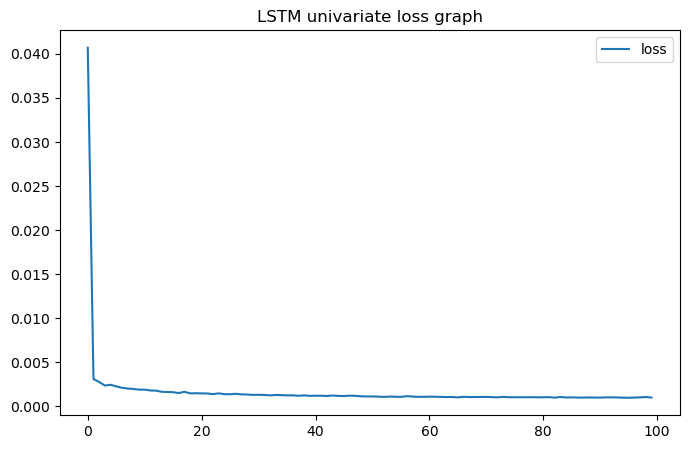

In [32]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.title('LSTM univariate loss graph')
plt.show()

In [33]:
sctsx = MinMaxScaler(feature_range=(0,1))
sctsx.fit(X_test.reshape(-1,1))
X_tests = sctsx.transform(X_test.reshape(-1,1))

In [34]:
sctsy = MinMaxScaler(feature_range=(0,1))
sctsy.fit(y_test.reshape(-1,1))

MinMaxScaler()

In [35]:
# version check for reshape
if versioncheck:
    X_tests =X_tests[:,:,newaxis]
else:
    pass

In [36]:
fhats = model.predict(X_tests)

In [37]:
hat_inv = sctsy.inverse_transform(fhats)
uhat_inv_p2 = hat_inv

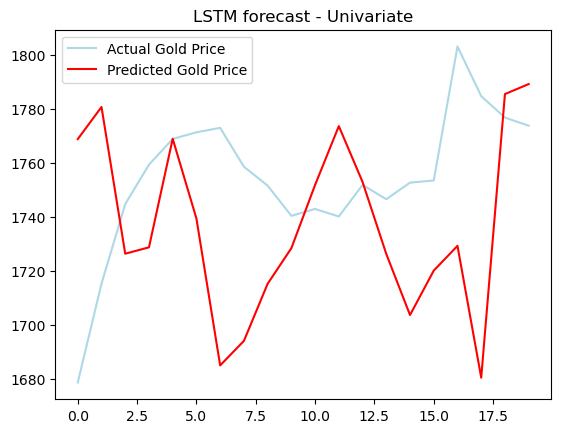

<Figure size 640x480 with 0 Axes>

In [38]:
plt.plot(y_test, color='lightblue', label='Actual Gold Price')
plt.plot(hat_inv, color='red',label='Predicted Gold Price')
plt.title('LSTM forecast - Univariate')
plt.legend()
plt.show()
plt.clf()

In [39]:
# metrics
mae_uv = mean_absolute_error(y_test, hat_inv)
mape_uv = mean_absolute_percentage_error(y_test, hat_inv)
mse_uv = mean_squared_error(y_test, hat_inv)
rmse_uv = np.sqrt(mse_uv)

In [40]:
print(f'MAE: {mae_uv}\nMAPE: {mape_uv}\nMSE: {mse_uv}\nRMSE: {rmse_uv}')

MAE: 39.30983398437498
MAPE: 0.022428960245772452
MSE: 2494.5146352297047
RMSE: 49.94511623001497


In [41]:
res_dict['model'].append('LSTM')
res_dict['type'].append('univariate')
res_dict['period'].append(2)
res_dict['MAE'].append(mae_uv)
res_dict['MAPE'].append(mape_uv)
res_dict['MSE'].append(mse_uv)
res_dict['RMSE'].append(rmse_uv)

# Univariate period 3

In [42]:
X_train, y_train = df['GoldLag'].iloc[:-20].values, df['Gold'].iloc[:-20].values
X_test, y_test = df['GoldLag'].iloc[-20:].values, df['Gold'].iloc[-20:].values

In [43]:
scx = MinMaxScaler(feature_range=(0,1))
scy = MinMaxScaler(feature_range=(0,1))
X_trains = scx.fit_transform(X_train.reshape(-1,1))
y_trains = scy.fit_transform(y_train.reshape(-1,1))

In [44]:
adam = Adam(lr=0.001)

In [45]:
# this is needed for python 3.7 , for keras and tf in python 3.10 comment out this cell
if versioncheck:
    from numpy import newaxis

    X_trains =X_trains[:,:,newaxis]
    y_trains.reshape(1,-1)
else:
    pass

In [46]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_trains.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "relu"))

model.compile(loss='mse', optimizer=adam)

print ('model compiled')

print (model.summary())

model compiled
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 50)             10400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 100)            60400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1) 

In [47]:
history = model.fit(X_trains, y_trains, batch_size=64, epochs=100, verbose=2, use_multiprocessing=True)

Epoch 1/100
 - 2s - loss: 0.0354
Epoch 2/100
 - 1s - loss: 0.0030
Epoch 3/100
 - 1s - loss: 0.0027
Epoch 4/100
 - 1s - loss: 0.0023
Epoch 5/100
 - 1s - loss: 0.0022
Epoch 6/100
 - 1s - loss: 0.0021
Epoch 7/100
 - 1s - loss: 0.0021
Epoch 8/100
 - 1s - loss: 0.0021
Epoch 9/100
 - 1s - loss: 0.0018
Epoch 10/100
 - 1s - loss: 0.0019
Epoch 11/100
 - 1s - loss: 0.0018
Epoch 12/100
 - 1s - loss: 0.0017
Epoch 13/100
 - 1s - loss: 0.0017
Epoch 14/100
 - 1s - loss: 0.0016
Epoch 15/100
 - 1s - loss: 0.0016
Epoch 16/100
 - 1s - loss: 0.0015
Epoch 17/100
 - 1s - loss: 0.0016
Epoch 18/100
 - 1s - loss: 0.0015
Epoch 19/100
 - 1s - loss: 0.0015
Epoch 20/100
 - 1s - loss: 0.0015
Epoch 21/100
 - 1s - loss: 0.0014
Epoch 22/100
 - 1s - loss: 0.0014
Epoch 23/100
 - 1s - loss: 0.0014
Epoch 24/100
 - 1s - loss: 0.0014
Epoch 25/100
 - 1s - loss: 0.0013
Epoch 26/100
 - 1s - loss: 0.0014
Epoch 27/100
 - 1s - loss: 0.0013
Epoch 28/100
 - 1s - loss: 0.0013
Epoch 29/100
 - 1s - loss: 0.0013
Epoch 30/100
 - 1s - lo

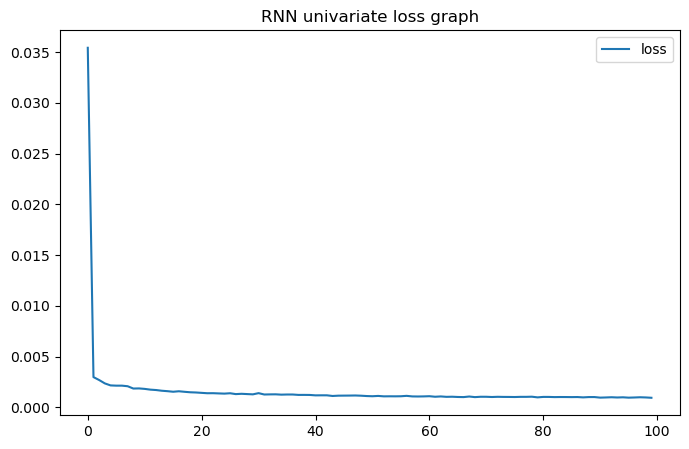

In [48]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.title('RNN univariate loss graph')
plt.show()

In [49]:
sctsx = MinMaxScaler(feature_range=(0,1))
sctsx.fit(X_test.reshape(-1,1))
X_tests = sctsx.transform(X_test.reshape(-1,1))

In [50]:
sctsy = MinMaxScaler(feature_range=(0,1))
sctsy.fit(y_test.reshape(-1,1))

MinMaxScaler()

In [51]:
# version check for reshape
if versioncheck:
    X_tests =X_tests[:,:,newaxis]
else:
    pass

In [52]:
fhats = model.predict(X_tests)

In [53]:
hat_inv = sctsy.inverse_transform(fhats)
uhat_inv_p3 = hat_inv

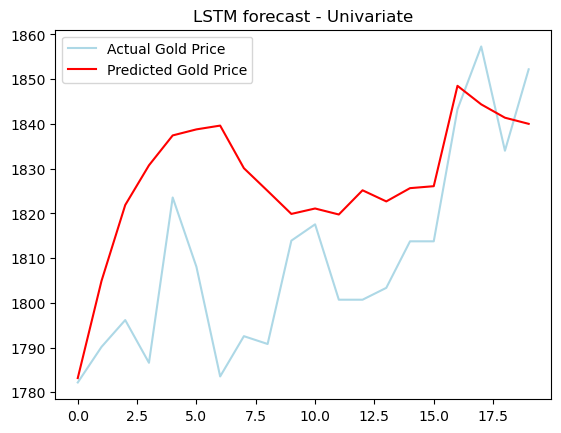

<Figure size 640x480 with 0 Axes>

In [54]:
plt.plot(y_test, color='lightblue', label='Actual Gold Price')
plt.plot(hat_inv, color='red',label='Predicted Gold Price')
plt.title('LSTM forecast - Univariate')
plt.legend()
plt.show()
plt.clf()

In [55]:
# metrics
mae_uv = mean_absolute_error(y_test, hat_inv)
mape_uv = mean_absolute_percentage_error(y_test, hat_inv)
mse_uv = mean_squared_error(y_test, hat_inv)
rmse_uv = np.sqrt(mse_uv)

In [56]:
print(f'MAE: {mae_uv}\nMAPE: {mape_uv}\nMSE: {mse_uv}\nRMSE: {rmse_uv}')

MAE: 19.614949951171877
MAPE: 0.010888609447986955
MSE: 588.0415717717714
RMSE: 24.249568486300358


In [57]:
res_dict['model'].append('LSTM')
res_dict['type'].append('univariate')
res_dict['period'].append(3)
res_dict['MAE'].append(mae_uv)
res_dict['MAPE'].append(mape_uv)
res_dict['MSE'].append(mse_uv)
res_dict['RMSE'].append(rmse_uv)

In [58]:
pd.DataFrame(res_dict)

,model,type,period,MAE,MAPE,MSE,RMSE
0,LSTM,univariate,1,16.756301,0.010146,379.466848,19.479909
1,LSTM,univariate,2,39.309834,0.022429,2494.514635,49.945116
2,LSTM,univariate,3,19.614950,0.010889,588.041572,24.249568


In [59]:
p1 = pd.DataFrame(uhat_inv_p1)
p1.index = df.iloc[-60:-40].index
p2 = pd.DataFrame(uhat_inv_p2)
p2.index = df.iloc[-40:-20].index
p3 = pd.DataFrame(uhat_inv_p3)
p3.index = df.iloc[-20:].index

Text(0.5, 0, 'Date')

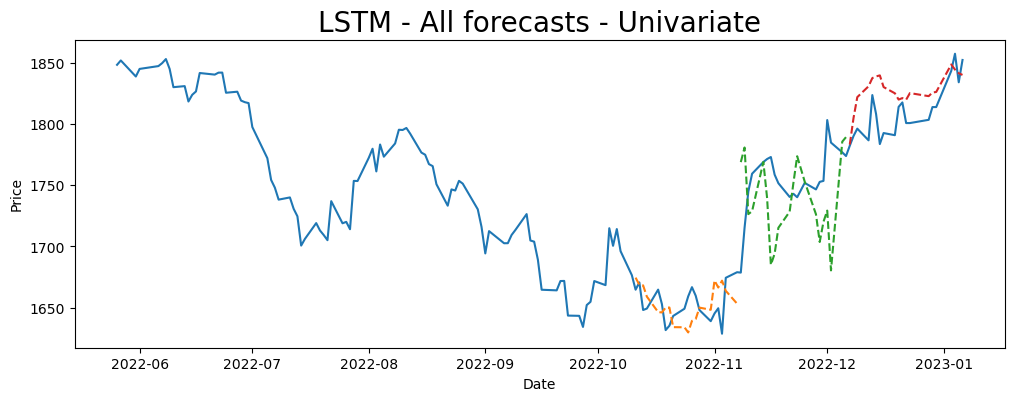

In [60]:
fig, ax = plt.subplots(figsize=(12,4))
plt.plot(df.iloc[-150:].index, df.iloc[-150:].Gold)
plt.plot(p1.index, p1[0], linestyle='--')
plt.plot(p2.index, p2[0], linestyle='--')
plt.plot(p3.index, p3[0], linestyle='--')
plt.title('LSTM - All forecasts - Univariate', fontsize=20)
plt.ylabel('Price')
plt.xlabel('Date')

---
# LSTM multivariate

In [61]:
dataset[['CrudeOilLag', 'S&P500Lag', 'FTSE250Lag']]  = dataset[['CrudeOil', 'S&P500', 'FTSE250']].shift(20)
dataset

,Gold,CrudeOil,S&P500,FTSE250,GoldLag,CrudeOilLag,S&P500Lag,FTSE250Lag
date,,,,,,,,
1986-01-02,326.30,25.56,209.59,1417.26,NaN,NaN,NaN,NaN
1986-01-03,326.75,26.00,210.88,1424.61,NaN,NaN,NaN,NaN
1986-01-06,328.00,26.53,210.65,1430.96,NaN,NaN,NaN,NaN
1986-01-07,330.00,25.85,213.80,1421.22,NaN,NaN,NaN,NaN
1986-01-08,332.60,25.87,207.97,1408.79,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-12-30,1813.75,80.16,3839.50,18853.00,1753.50,80.48,4080.11,19163.33
2023-01-03,1843.25,76.87,3824.14,19134.34,1803.15,81.06,4076.57,19409.42
2023-01-04,1857.30,72.82,3852.97,19391.07,1784.75,79.86,4071.70,19363.28


In [62]:
df = dataset[['Gold', 'CrudeOilLag', 'S&P500Lag', 'FTSE250Lag']].copy()

In [63]:
df.dropna(inplace=True)
df

,Gold,CrudeOilLag,S&P500Lag,FTSE250Lag
date,,,,
1986-01-30,358.00,25.56,209.59,1417.26
1986-01-31,350.50,26.00,210.88,1424.61
1986-02-03,347.30,26.53,210.65,1430.96
1986-02-04,338.60,25.85,213.80,1421.22
1986-02-05,337.30,25.87,207.97,1408.79
...,...,...,...,...
2022-12-30,1813.75,80.48,4080.11,19163.33
2023-01-03,1843.25,81.06,4076.57,19409.42
2023-01-04,1857.30,79.86,4071.70,19363.28


## Period 1

In [64]:
X_train, y_train = df[['CrudeOilLag', 'S&P500Lag', 'FTSE250Lag']].iloc[:-60].values, df['Gold'].iloc[:-60].values
X_test, y_test = df[['CrudeOilLag', 'S&P500Lag', 'FTSE250Lag']].iloc[-60:-40].values, df['Gold'].iloc[-60:-40].values

In [65]:
scx = MinMaxScaler(feature_range=(0,1))
scy = MinMaxScaler(feature_range=(0,1))
X_trains = scx.fit_transform(X_train)
y_trains = scy.fit_transform(y_train.reshape(-1,1))

In [66]:
X_train

array([[   25.56,   209.59,  1417.26],
       [   26.  ,   210.88,  1424.61],
       [   26.53,   210.65,  1430.96],
       ...,
       [   82.5 ,  3979.87, 18811.48],
       [   84.04,  4006.18, 18878.29],
       [   87.27,  4067.36, 19188.03]])

In [67]:
adam = Adam(lr=0.001)

In [68]:
if versioncheck:
    X_trains =X_trains[:,:,newaxis]
    #y_trains =y_trains[:,:,newaxis]
else:
    pass

In [69]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_trains.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "relu"))

model.compile(loss='mse', optimizer=adam, metrics=['mse'])

print ('model compiled')

print (model.summary())

model compiled
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 3, 50)             10400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 3, 50)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 3, 100)            60400     
_________________________________________________________________
dropout_11 (Dropout)         (None, 3, 100)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 200)               240800    
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1) 

In [70]:
history = model.fit(X_trains, y_trains, batch_size=512, epochs=100, verbose=2, use_multiprocessing=True)

Epoch 1/100
 - 2s - loss: 0.1065 - mse: 0.1065
Epoch 2/100
 - 1s - loss: 0.0507 - mse: 0.0507
Epoch 3/100
 - 2s - loss: 0.0226 - mse: 0.0226
Epoch 4/100
 - 1s - loss: 0.0206 - mse: 0.0206
Epoch 5/100
 - 1s - loss: 0.0195 - mse: 0.0195
Epoch 6/100
 - 1s - loss: 0.0182 - mse: 0.0182
Epoch 7/100
 - 1s - loss: 0.0178 - mse: 0.0178
Epoch 8/100
 - 1s - loss: 0.0173 - mse: 0.0173
Epoch 9/100
 - 1s - loss: 0.0167 - mse: 0.0167
Epoch 10/100
 - 1s - loss: 0.0161 - mse: 0.0161
Epoch 11/100
 - 1s - loss: 0.0157 - mse: 0.0157
Epoch 12/100
 - 1s - loss: 0.0152 - mse: 0.0152
Epoch 13/100
 - 1s - loss: 0.0146 - mse: 0.0146
Epoch 14/100
 - 1s - loss: 0.0142 - mse: 0.0142
Epoch 15/100
 - 1s - loss: 0.0137 - mse: 0.0137
Epoch 16/100
 - 1s - loss: 0.0133 - mse: 0.0133
Epoch 17/100
 - 1s - loss: 0.0128 - mse: 0.0128
Epoch 18/100
 - 1s - loss: 0.0126 - mse: 0.0126
Epoch 19/100
 - 1s - loss: 0.0124 - mse: 0.0124
Epoch 20/100
 - 1s - loss: 0.0121 - mse: 0.0121
Epoch 21/100
 - 1s - loss: 0.0118 - mse: 0.0118
E

In [71]:
sctsx = MinMaxScaler(feature_range=(0,1))
sctsx.fit(X_test)
X_tests = sctsx.transform(X_test)

In [72]:
sctsy = MinMaxScaler(feature_range=(0,1))
sctsy.fit(y_test.reshape(-1,1))
#ytt = sctsy.transform(y_test.reshape(-1,1))

MinMaxScaler()

In [73]:
if versioncheck:
    X_tests =X_tests[:,:,newaxis]
    #y_trains =y_trains[:,:,newaxis]
else:
    pass

In [74]:
fhats = model.predict(X_tests)

In [75]:
hat_inv = sctsy.inverse_transform(fhats)
mvhat_inv_p1 = hat_inv

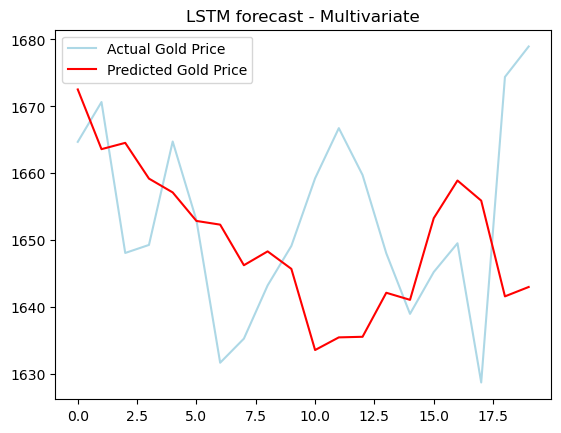

<Figure size 640x480 with 0 Axes>

In [76]:
plt.plot(y_test, color='lightblue', label='Actual Gold Price')
plt.plot(hat_inv, color='red',label='Predicted Gold Price')
plt.title('LSTM forecast - Multivariate')
plt.legend()
plt.show()
plt.clf()

In [77]:
# metrics
mae_mv = mean_absolute_error(y_test, hat_inv)
mape_mv = mean_absolute_percentage_error(y_test, hat_inv)
mse_mv = mean_squared_error(y_test, hat_inv)
rmse_mv = np.sqrt(mse_mv)

In [78]:
print(f'MAE: {mae_mv}\nMAPE: {mape_mv}\nMSE: {mse_mv}\nRMSE: {rmse_mv}')

MAE: 14.572421875000021
MAPE: 0.008797128206676828
MSE: 331.8333392772682
RMSE: 18.21629323647564


In [79]:
res_dict['model'].append('LSTM')
res_dict['type'].append('multivariate')
res_dict['period'].append(1)
res_dict['MAE'].append(mae_mv)
res_dict['MAPE'].append(mape_mv)
res_dict['MSE'].append(mse_mv)
res_dict['RMSE'].append(rmse_mv)

## Period 2

In [80]:
X_train, y_train = df[['CrudeOilLag', 'S&P500Lag', 'FTSE250Lag']].iloc[:-40].values, df['Gold'].iloc[:-40].values
X_test, y_test = df[['CrudeOilLag', 'S&P500Lag', 'FTSE250Lag']].iloc[-40:-20].values, df['Gold'].iloc[-40:-20].values

In [81]:
scx = MinMaxScaler(feature_range=(0,1))
scy = MinMaxScaler(feature_range=(0,1))
X_trains = scx.fit_transform(X_train)
y_trains = scy.fit_transform(y_train.reshape(-1,1))

In [82]:
X_train

array([[   25.56,   209.59,  1417.26],
       [   26.  ,   210.88,  1424.61],
       [   26.53,   210.65,  1430.96],
       ...,
       [   88.9 ,  3744.52, 17632.64],
       [   93.07,  3639.66, 17353.28],
       [   91.6 ,  3612.39, 17125.29]])

In [83]:
adam = Adam(lr=0.001)

In [84]:
if versioncheck:
    X_trains =X_trains[:,:,newaxis]
    #y_trains =y_trains[:,:,newaxis]
else:
    pass

In [85]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_trains.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "relu"))

model.compile(loss='mse', optimizer=adam, metrics=['mse'])

print ('model compiled')

print (model.summary())

model compiled
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 3, 50)             10400     
_________________________________________________________________
dropout_13 (Dropout)         (None, 3, 50)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 3, 100)            60400     
_________________________________________________________________
dropout_14 (Dropout)         (None, 3, 100)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 200)               240800    
_________________________________________________________________
dropout_15 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1) 

In [86]:
history = model.fit(X_trains, y_trains, batch_size=512, epochs=100, verbose=2, use_multiprocessing=True)

Epoch 1/100
 - 3s - loss: 0.1050 - mse: 0.1050
Epoch 2/100
 - 2s - loss: 0.0497 - mse: 0.0497
Epoch 3/100
 - 1s - loss: 0.0227 - mse: 0.0227
Epoch 4/100
 - 2s - loss: 0.0203 - mse: 0.0203
Epoch 5/100
 - 1s - loss: 0.0191 - mse: 0.0191
Epoch 6/100
 - 1s - loss: 0.0186 - mse: 0.0186
Epoch 7/100
 - 2s - loss: 0.0179 - mse: 0.0179
Epoch 8/100
 - 2s - loss: 0.0172 - mse: 0.0172
Epoch 9/100
 - 1s - loss: 0.0166 - mse: 0.0166
Epoch 10/100
 - 1s - loss: 0.0160 - mse: 0.0160
Epoch 11/100
 - 1s - loss: 0.0155 - mse: 0.0155
Epoch 12/100
 - 1s - loss: 0.0150 - mse: 0.0150
Epoch 13/100
 - 1s - loss: 0.0143 - mse: 0.0143
Epoch 14/100
 - 1s - loss: 0.0141 - mse: 0.0141
Epoch 15/100
 - 1s - loss: 0.0133 - mse: 0.0133
Epoch 16/100
 - 1s - loss: 0.0131 - mse: 0.0131
Epoch 17/100
 - 1s - loss: 0.0126 - mse: 0.0126
Epoch 18/100
 - 1s - loss: 0.0124 - mse: 0.0124
Epoch 19/100
 - 2s - loss: 0.0122 - mse: 0.0122
Epoch 20/100
 - 1s - loss: 0.0119 - mse: 0.0119
Epoch 21/100
 - 1s - loss: 0.0117 - mse: 0.0117
E

In [87]:
sctsx = MinMaxScaler(feature_range=(0,1))
sctsx.fit(X_test)
X_tests = sctsx.transform(X_test)

In [88]:
sctsy = MinMaxScaler(feature_range=(0,1))
sctsy.fit(y_test.reshape(-1,1))
#ytt = sctsy.transform(y_test.reshape(-1,1))

MinMaxScaler()

In [89]:
if versioncheck:
    X_tests =X_tests[:,:,newaxis]
    #y_trains =y_trains[:,:,newaxis]
else:
    pass

In [90]:
fhats = model.predict(X_tests)

In [91]:
hat_inv = sctsy.inverse_transform(fhats)
mvhat_inv_p2 = hat_inv

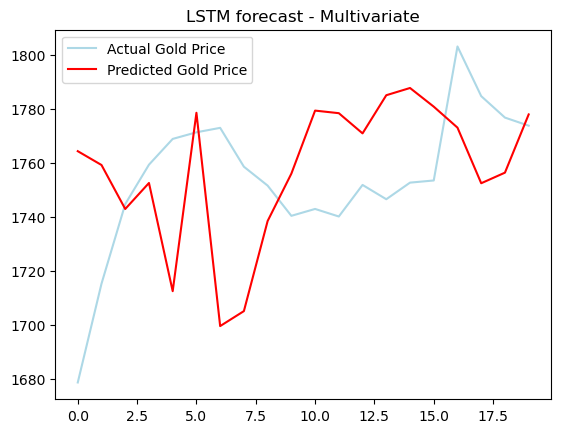

<Figure size 640x480 with 0 Axes>

In [92]:
plt.plot(y_test, color='lightblue', label='Actual Gold Price')
plt.plot(hat_inv, color='red',label='Predicted Gold Price')
plt.title('LSTM forecast - Multivariate')
plt.legend()
plt.show()
plt.clf()

In [93]:
# metrics
mae_mv = mean_absolute_error(y_test, hat_inv)
mape_mv = mean_absolute_percentage_error(y_test, hat_inv)
mse_mv = mean_squared_error(y_test, hat_inv)
rmse_mv = np.sqrt(mse_mv)

In [94]:
print(f'MAE: {mae_mv}\nMAPE: {mape_mv}\nMSE: {mse_mv}\nRMSE: {rmse_mv}')

MAE: 31.96784667968749
MAPE: 0.018298941403958213
MSE: 1512.0379264783846
RMSE: 38.88493186927791


In [95]:
res_dict['model'].append('LSTM')
res_dict['type'].append('multivariate')
res_dict['period'].append(2)
res_dict['MAE'].append(mae_mv)
res_dict['MAPE'].append(mape_mv)
res_dict['MSE'].append(mse_mv)
res_dict['RMSE'].append(rmse_mv)

## Period 3

In [96]:
X_train, y_train = df[['CrudeOilLag', 'S&P500Lag', 'FTSE250Lag']].iloc[:-20].values, df['Gold'].iloc[:-20].values
X_test, y_test = df[['CrudeOilLag', 'S&P500Lag', 'FTSE250Lag']].iloc[-20:].values, df['Gold'].iloc[-20:].values

In [97]:
scx = MinMaxScaler(feature_range=(0,1))
scy = MinMaxScaler(feature_range=(0,1))
X_trains = scx.fit_transform(X_train)
y_trains = scy.fit_transform(y_train.reshape(-1,1))

In [98]:
X_train

array([[   25.56,   209.59,  1417.26],
       [   26.  ,   210.88,  1424.61],
       [   26.53,   210.65,  1430.96],
       ...,
       [   88.14,  3719.89, 18109.61],
       [   92.58,  3770.55, 18341.57],
       [   91.8 ,  3806.8 , 18559.57]])

In [99]:
adam = Adam(lr=0.001)

In [100]:
if versioncheck:
    X_trains =X_trains[:,:,newaxis]
    #y_trains =y_trains[:,:,newaxis]
else:
    pass

In [101]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_trains.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "relu"))

model.compile(loss='mse', optimizer=adam, metrics=['mse'])

print ('model compiled')

print (model.summary())

model compiled
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 3, 50)             10400     
_________________________________________________________________
dropout_16 (Dropout)         (None, 3, 50)             0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 3, 100)            60400     
_________________________________________________________________
dropout_17 (Dropout)         (None, 3, 100)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 200)               240800    
_________________________________________________________________
dropout_18 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1) 

In [102]:
history = model.fit(X_trains, y_trains, batch_size=512, epochs=100, verbose=2, use_multiprocessing=True)

Epoch 1/100
 - 3s - loss: 0.1102 - mse: 0.1102
Epoch 2/100
 - 1s - loss: 0.0540 - mse: 0.0540
Epoch 3/100
 - 1s - loss: 0.0239 - mse: 0.0239
Epoch 4/100
 - 1s - loss: 0.0213 - mse: 0.0213
Epoch 5/100
 - 1s - loss: 0.0199 - mse: 0.0199
Epoch 6/100
 - 1s - loss: 0.0190 - mse: 0.0190
Epoch 7/100
 - 1s - loss: 0.0180 - mse: 0.0180
Epoch 8/100
 - 1s - loss: 0.0172 - mse: 0.0172
Epoch 9/100
 - 1s - loss: 0.0162 - mse: 0.0162
Epoch 10/100
 - 1s - loss: 0.0156 - mse: 0.0156
Epoch 11/100
 - 1s - loss: 0.0154 - mse: 0.0154
Epoch 12/100
 - 1s - loss: 0.0146 - mse: 0.0146
Epoch 13/100
 - 1s - loss: 0.0140 - mse: 0.0140
Epoch 14/100
 - 1s - loss: 0.0139 - mse: 0.0139
Epoch 15/100
 - 1s - loss: 0.0134 - mse: 0.0134
Epoch 16/100
 - 1s - loss: 0.0130 - mse: 0.0130
Epoch 17/100
 - 1s - loss: 0.0129 - mse: 0.0129
Epoch 18/100
 - 1s - loss: 0.0127 - mse: 0.0127
Epoch 19/100
 - 1s - loss: 0.0124 - mse: 0.0124
Epoch 20/100
 - 1s - loss: 0.0121 - mse: 0.0121
Epoch 21/100
 - 1s - loss: 0.0120 - mse: 0.0120
E

In [103]:
sctsx = MinMaxScaler(feature_range=(0,1))
sctsx.fit(X_test)
X_tests = sctsx.transform(X_test)

In [104]:
sctsy = MinMaxScaler(feature_range=(0,1))
sctsy.fit(y_test.reshape(-1,1))
#ytt = sctsy.transform(y_test.reshape(-1,1))

MinMaxScaler()

In [105]:
if versioncheck:
    X_tests =X_tests[:,:,newaxis]
    #y_trains =y_trains[:,:,newaxis]
else:
    pass

In [106]:
fhats = model.predict(X_tests)

In [107]:
hat_inv = sctsy.inverse_transform(fhats)
mvhat_inv_p3 = hat_inv

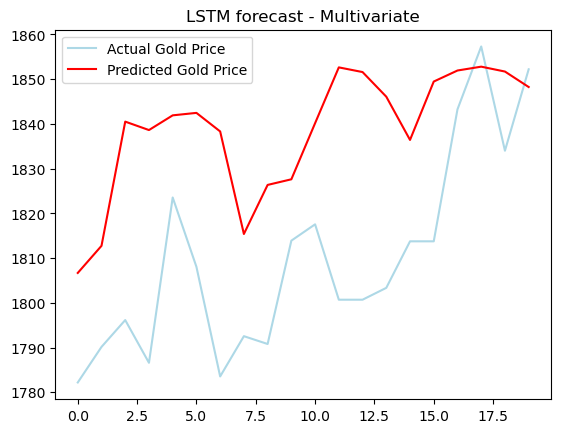

<Figure size 640x480 with 0 Axes>

In [108]:
plt.plot(y_test, color='lightblue', label='Actual Gold Price')
plt.plot(hat_inv, color='red',label='Predicted Gold Price')
plt.title('LSTM forecast - Multivariate')
plt.legend()
plt.show()
plt.clf()

In [109]:
# metrics
mae_mv = mean_absolute_error(y_test, hat_inv)
mape_mv = mean_absolute_percentage_error(y_test, hat_inv)
mse_mv = mean_squared_error(y_test, hat_inv)
rmse_mv = np.sqrt(mse_mv)

In [110]:
print(f'MAE: {mae_mv}\nMAPE: {mape_mv}\nMSE: {mse_mv}\nRMSE: {rmse_mv}')

MAE: 29.222316894531254
MAPE: 0.01622291888128108
MSE: 1105.6058137778643
RMSE: 33.2506513286261


In [111]:
res_dict['model'].append('LSTM')
res_dict['type'].append('multivariate')
res_dict['period'].append(3)
res_dict['MAE'].append(mae_mv)
res_dict['MAPE'].append(mape_mv)
res_dict['MSE'].append(mse_mv)
res_dict['RMSE'].append(rmse_mv)

In [112]:
pd.DataFrame(res_dict)

,model,type,period,MAE,MAPE,MSE,RMSE
0,LSTM,univariate,1,16.756301,0.010146,379.466848,19.479909
1,LSTM,univariate,2,39.309834,0.022429,2494.514635,49.945116
2,LSTM,univariate,3,19.614950,0.010889,588.041572,24.249568
3,LSTM,multivariate,1,14.572422,0.008797,331.833339,18.216293
4,LSTM,multivariate,2,31.967847,0.018299,1512.037926,38.884932
5,LSTM,multivariate,3,29.222317,0.016223,1105.605814,33.250651


Text(0.5, 0, 'Date')

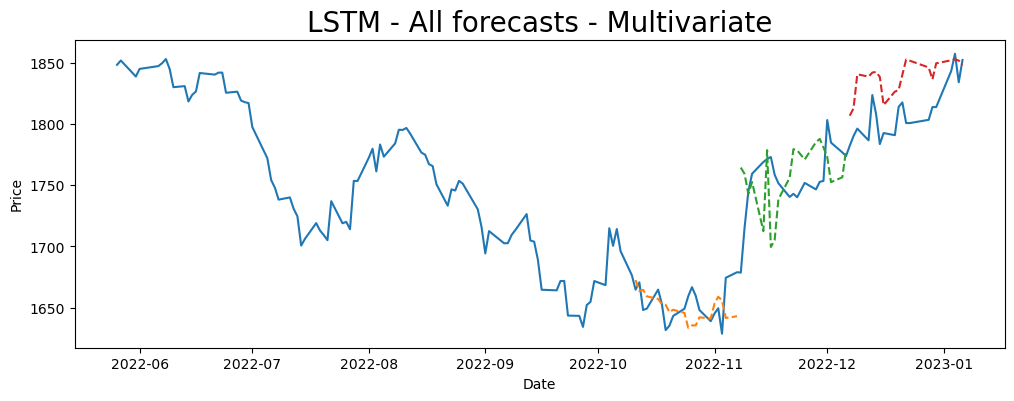

In [113]:
p1 = pd.DataFrame(mvhat_inv_p1)
p1.index = df.iloc[-60:-40].index
p2 = pd.DataFrame(mvhat_inv_p2)
p2.index = df.iloc[-40:-20].index
p3 = pd.DataFrame(mvhat_inv_p3)
p3.index = df.iloc[-20:].index

fig, ax = plt.subplots(figsize=(12,4))
plt.plot(df.iloc[-150:].index, df.iloc[-150:].Gold)
plt.plot(p1.index, p1[0], linestyle='--')
plt.plot(p2.index, p2[0], linestyle='--')
plt.plot(p3.index, p3[0], linestyle='--')
plt.title('LSTM - All forecasts - Multivariate', fontsize=20)
plt.ylabel('Price')
plt.xlabel('Date')

---
# Diebold-Mariano


In [114]:
from dieboldmariano import dm_test

In [115]:
# period 1

dm_test(list(df.iloc[-60:-40].Gold), list(uhat_inv_p1.reshape(1,-1)[0]), list(mvhat_inv_p1.reshape(1,-1)[0]))

(0.5055315956380041, 0.6189998502815864)

In [116]:
# period 2
dm_test(list(df.iloc[-40:-20].Gold), list(uhat_inv_p2.reshape(1,-1)[0]), list(mvhat_inv_p2.reshape(1,-1)[0]))

(1.68201591762803, 0.10892871632889921)

In [117]:
dm_test(list(df.iloc[-20:].Gold), list(uhat_inv_p3.reshape(1,-1)[0]), list(mvhat_inv_p3.reshape(1,-1)[0]))

(-2.9669296745524694, 0.00792029820324772)